# Informed Classifier

## Project Introduction: Time Series Classification
Imagine we have two time series and our task is to distinguish between them. 
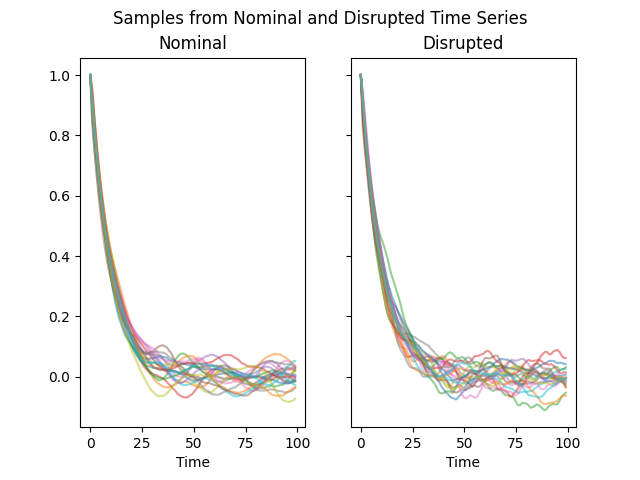

How would you approach building a classifier for these series? 

They look almost identical, though there's some more high frequency noise in the Disrupted time series samples and overall more variance. Maybe you'd explore engineering some good features for a neural network or a decision tree that would capture the high frequency content of the second time series. Maybe you'd fit the mean with a polynomial and the noise with a seasonal ARMA -- there does seem to be a "random walk" element to the processes, with maybe periodic noise on top of the disrupted model.

### If you know the conditional distributions, Bayes is Best
What if you knew the process that both of these series came from perfectly? If you can write down P(X|C=c), using a Bayes classifier would give you optimal results. [see proof here] https://en.wikipedia.org/wiki/Bayes_classifier

### Definitions
I'll occasionally be swapping between calling these time series Process A & B and calling them nominal and disrupted. Process B will always be the disrupted case and Process A will be the nominal case. I'll talk about the design process for these distributions in the Generative Processes section (including why the covariance and mean functions look the way they do).

I also vary between calling them 100-dimensional Gaussians and finite-time, discrete Gaussian Process. Hopefully this is alright!

# Dataset
## Generative processes
I went through several iterations of designing these processes. It was quite challenging to make trajectories (samples from our 100-dim Gaussian / a sample from our finite-time, discrete Gaussian Process) that were distinguishable by eye, but were not trival to classify. The initial plot I showed in the project report generated 100% accuracy from the true-distribution Bayes classifier, almost 100% accuracy from the SVM and the fitted GP models.

[copy figure from project report]

Process A represents a "normal" or "nominal" run of a machine, trajectory of a dynamical system, etc. Process B was designed to be an augmented version of Process A, with additional terms in the covariance matrix to simulate "something going wrong". That might be additional higher-frequency, correlated vibrations in your experiment setup from something like a loose screw! Or something more like an additional force you didn't expect (though most forces wouldn't end up in your covariance matrix like that).

### Covariance Matrix
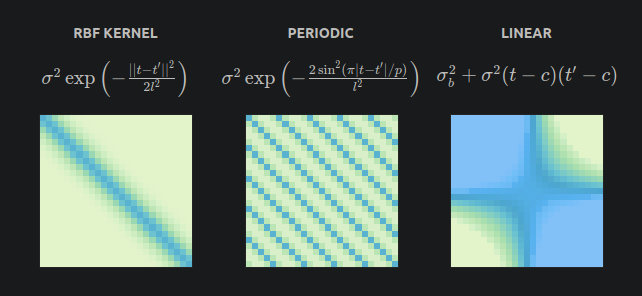\
***Figure: Kernel / covariance matrix types for Gaussian Processes, from [Ref 1. Distill.io](https://distill.pub/2019/visual-exploration-gaussian-processes/)***

The covariance matrix for Process B was chosen to be a linear combination of all three.
[Heat Map of Kernel]

## Data Preparation
Each generative model is versioned and data is generated through ```poetry run python gen_data.py --config config_file_name.yaml```.
The data is then saved as separate npy files (one per sample trajectory) under the full experiment name (versioned with the contents of the config file and the version of the generative models) into separate directories for `train`, `test`, and `validation` splits. You can see how this is organized in "Overview of Code" section.

`gen_data.py` instantiates a nominal and disrupted model and generates samples from each. The labels are created based on which model was called, the data is shuffled, and then saved to file.

In [1]:
# To generate the large dataset (50k samples), uncomment and run this cell
# !poetry run python gen_data.py --config large_samples.yaml

# Re-written version of `gen_data` script to be runnable here:
```py
### CONFIGURATION
config, config_filename = get_config()
dim = config["dim"]
samples = config["samples"]
ratio = config["ratio"]
train_test_validation_split = config["train_test_validation_split"]
assert np.isclose(sum(train_test_validation_split), 1.0)

#### MODELS
disrupted = generative_models.DisruptedModel(dim)
nominal = generative_models.NominalModel(dim)

# Add model versions to config
old_experiment_name = config["experiment_name"]
del config["experiment_name"]
with open(config_filename, "w") as file:
    yaml.dump(config, file)
config["experiment_name"] = update_experiment_name(
    old_experiment_name, nominal, disrupted
)

#### SAMPLING
disrupted_data = disrupted.sample(int(samples * (1 - ratio)))
disrupted_labels = np.ones((disrupted_data.shape[0], 1))
nominal_data = nominal.sample(int(samples * (ratio)))
nominal_labels = np.zeros((nominal_data.shape[0], 1))

#### PREPARING DATA TO WRITE
x_data = np.vstack((disrupted_data, nominal_data))
y_data = np.vstack((disrupted_labels, nominal_labels))
data = np.hstack((x_data, y_data))

# Ensure that the data is randomly shuffled, preserving labels with samples.
np.random.shuffle(data)

#### WRITING TO FILE
if not os.path.exists("data"):
    os.makedirs("data")

indicies = [0]
for i in range(0, len(train_test_validation_split)):
    indicies.append(indicies[i] + int(samples * train_test_validation_split[i]))

sections = [
    f"data/{config['experiment_name']}/train",
    f"data/{config['experiment_name']}/test",
    f"data/{config['experiment_name']}/validation",
```

## Overview of code
The associated repo is here: https://github.com/JuLieAlgebra/informed_classifier.

The project is set up in the following way (ignoring hidden files like `.gihub`):

.\
├─ config\
├─ data\
│   ├── Example experiment name: 100dim_10000samples_0.5ratio_0.0006train_0.8994test_0.1val\
│   │   ├── test\
│   │   ├── train\
│   │   └── validation\
│   ...\
├─ gen_data.py\
├─ informed_classification\
│   ├── `__init__`.py\
│   ├── bayes_classifier.py\
│   ├── common_utilities.py\
│   ├── generative_models.py\
│   ├── models.py\
│   └── naive_ml.py\
├─ poetry.lock\
├─ pyproject.toml\
├─ README.md\
├─ Report.ipynb\
├─ scripts\
│   ├── disrupted.py\
│   ├── evaluate_bayes.py\
│   └── evaluate_svm.py\
└─ tests\
    ├── test_gen_models.py\
    └── test_models.py


If you'd like, you can install Poetry and follow the three lines in the README to run this work for yourself.
There are tests for every module within.

Some small quality of life additions is a basic CI that runs the existing tests on every push so I can't commit code that breaks existing functionality without knowing about it (and ensure that the project enviroment is always fully specified). I also have style linters running with pre-commit hooks -- both `isort` and `black`, which manage the organization of your import statements and the code style.

## Bayes Classifier
The Bayes classifier takes in a list of classes and a prior over those classes. It calculates the posterior by 

- Purpose: To classify data points based on the maximum a posteriori (MAP) probability.
- Inputs:
    - prior: A list of prior probabilities $ p(c) $ for each class.
    - classes: A list of generative models corresponding to each class.
- Methods:
    - classify: Determines the most likely class for a given data point.
    - posterior: Computes the posterior probabilities for each class given a data point.
    - evidence: Calculates the evidence term $ p(x) $ in Bayes' Theorem.
    - likelihood: Computes the likelihood $ p(x|c) $ of observing the data point under each generative model.
    - joint: Computes the joint probability $ p(x, c) $.

Mathematical Formulation
Bayes' Theorem

The core of Bayesian classification is Bayes' Theorem, which is expressed as:

$ p(c|x) = \frac{p(x|c)p(c)}{p(x)} $

Where:

Methods

- `classify(x: np.array) -> np.array`\
        Computes the MAP by selecting the class with the highest posterior probability for each data point $ x $.
        MAP is given by:\
        $ \text{MAP} = \arg\max_c p(c|x) $

-  `posterior(x: np.array) -> list[float]`\
        Calculates the posterior probability $ p(c|x) $ for each class using Bayes' Theorem.
        Handles cases where non-finite values are encountered by replacing them with a uniform distribution.

-  `evidence(x: np.array) -> float`\
        Computes $ p(x) $, the total probability of observing $ x $, as the sum of the joint probabilities over all classes:\
        $ p(x) = \sum_c p(x, c) $

-  `likelihood(c: GenerativeModel, x: np.array) -> float`\
        Computes $ p(x|c) $, the likelihood of $ x $ under the generative model for class $ c $.

- `joint(c: GenerativeModel, x: np.array) -> float`\
        Calculates the joint probability $ p(x, c) $ as the product of the likelihood and the prior:\
        $ p(x, c) = p(x|c)p(c) $

# Situations to sweep:
For a variety of training set sizes...
- Process A and B are known.
- Process A is known, B's mean is known.
- Process A is known, B's covariance is known.
- Process A is known, only the family of Process B is known.
- Process A's mean is known, B's mean is known.
- Process A's covariance is known, B's covariance is known.
- Only the family of Process A and Process B are known.
- Nothing is known (use traditional discriminative models, like an SVM or neural network).

## Calculating Performance
Calculate average performance of each model on different size datasets. 
Do this by generating a large dataset, then for each desired dataset size, collect the performance metrics across k-fold validation.

Examining the performance of these models in very low-data regimes can be tricky. For n=10 training samples, fitting the mean and cov function of Process A & B saw testing (8,000) and validation (1,000) set accuracies from 90% to 61%, depending on which ten generated trajectories the models were allowed to train on. This emphasized the need for gauging the *average* and *median* accuracies for testing & validation, across a large number of repeated low-data trainings.

[TODO -- Estimates of error bars on accuracy based on accuracy scores across different slices of the training data]
### Metrics
I tracked metrics suitable for a classification task -- precision, recall, accuracy, and the f1 score. The variance in the boxplots you see are the results of those scores across the 5 k-fold splits of the training data.
Despite talking about time series and fitting to them, there is no real notion of "residuals" here, as the models are not predictive, but generative. That's  [TODO]

### Extensions and their Challenges
Something that would be more deep-learning based, but is a realistic extension of this work to more scenarios, would be if Process A was a dynamical system (with control inputs, even) whose description is pretty well known, but Process B represented an anomalous state with relatively little data.

Turning the dynamical system into `P(X=x|C=c)` for the classification task presents a small challenge, but one that's quite common and can be tackled in many different ways. 

## Real-World Datasets
Unfortunately the fusion community does not open source most of their data. Disruption databases are usually held by the organization responsible for the tokamak.

However, any classification task where the classes are relatively-known dynamical systems or the family of distributions that the data comes from is known are applicable. 

## Challenges Encountered
Along the way, I ran into a number of numerical instability issues and challenges with forming a non-singular covariance matrix.
The covariance matrix for the generated processes was 100x100 and the Gaussians themselves were, of course, 100 dimensional. The determinant of this covariance matrix can be extraordinarily tiny for these high dimensions, which introduces some oddnesses down the line.


### Numerical issues with small-sample sizes and singular (estimated) covariance matrices

For very small sample sizes (I found it to be often true <40), the covariance of data sampled from a hundred dimensional Gaussian can become almost zero along certain dimensions for small sample sizes very easily -- I added a demonstration of this in the `scripts` folder. [TODO]

To combat this, I compute the eigendecomposition of the covariance matrix and clip very small eigenvalues below 1e-6 to 1e-6 (anything smaller resulted in nan's and divide by zero errors as the determinant became numerically zero). Then I put the matrix back together. This is a relatively common technique for dealing with singular matrices, but I actually haven't heard a name for this process. 

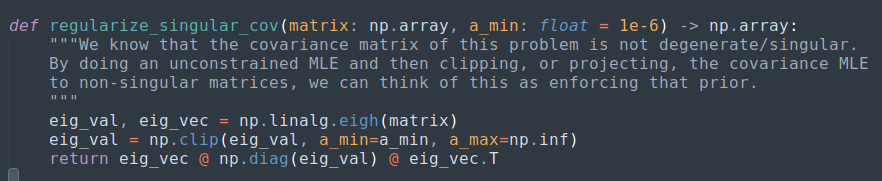

I'm thinking about this procedure as enforcing our strong prior that the underlying covariance matrix is **not singular**. We're projecting the matrix that would be numerically singular (thanks to numerical things) back into the non-singular matrix space. This takes our determinant of these "numerically" singular matrices from `is_close(det(A), 0.0) = True` to `is_close(det(A), 0.0) = False`.

# Conclusions
## Fitting Gaussian Processes
I claimed that we tested a large variety of scenarios representing differing amounts of prior knowledge about the distributions of Process A and Process B. However, nowhere did I fit A and B based on priors about the structure of the mean or covariance function. The mean function is an exponential curve that depends on time and the covariance function is shift-invariant. 

You could easily imagine a scenario where we know (perhaps from first principles models) that the mean function should be exponentially decaying, but we don't know the coefficients of that curve. We could have fit Process A and B based on that knowledge as well. However, this would likely involve making this system differentiable (& just-in-time compiled for the sake of runtime) in order to backprop to get gradients of the proposed mean function with respect to the model outputs. 

For fitting the shift-invariant covariance matrix, I'm not sure how I would fit a Toeplitz matrix in a way that respects the structure, but hopefully someone has published or written something on that kind of constrained optimization. 

These would both yield even better performance than our current mean and covariance fitting procedures, which are just the MLE of a general Gaussian Process.

In an ideal world, we also would [talk about consequence modeling].


# Plots to generate
- heat map of covariance matrix
- Plotting exponential mean func
- Gaussian-ness of generated data?
- S curve of model accuracy (and like recall, etc) with varying N on the x axis for each model.
- average residual??? (not applicable)

# References
[1] https://distill.pub/2019/visual-exploration-gaussian-processes/